使用qwen-qwq已经炸掉了，接下来试试换一个方法。使用其他大模型尝试，这个是openai的

1. 导入依赖库

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from glob import glob

# TensorFlow / Keras 相关
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# scikit-learn 相关
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')


2025-03-16 22:43:59.767850: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 22:43:59.801505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 22:43:59.801523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 22:43:59.802303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 22:43:59.807729: I tensorflow/core/platform/cpu_feature_guar

2. 定义全局参数及数据预处理函数

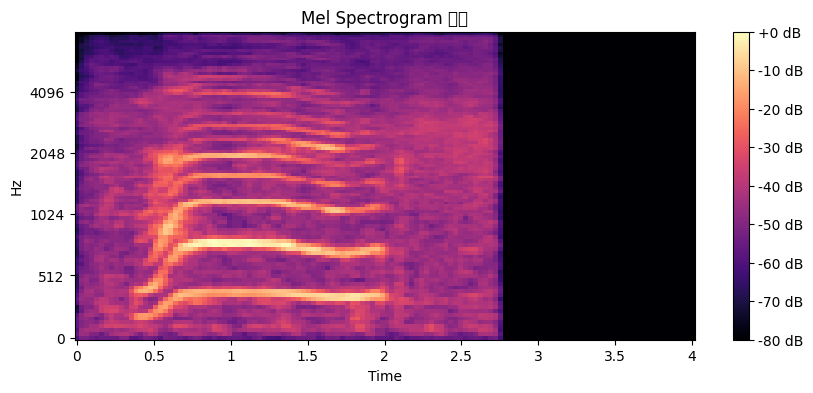

In [4]:
# 全局参数配置
SAMPLE_RATE = 16000
DURATION = 4.0  # 音频时长（秒），不足部分补零，多余则截断
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)

def load_audio_file(file_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """
    加载音频文件，确保采样率为 SAMPLE_RATE，长度固定为 DURATION 秒
    """
    audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    if len(audio) < SAMPLES_PER_TRACK:
        # 右侧补零
        audio = np.pad(audio, (0, SAMPLES_PER_TRACK - len(audio)), mode='constant')
    else:
        audio = audio[:SAMPLES_PER_TRACK]
    return audio

def compute_mel_spectrogram(audio, sample_rate=SAMPLE_RATE, n_mels=96, n_fft=2048, hop_length=512):
    """
    计算 Mel spectrogram，并转换为对数尺度
    """
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# 示例：加载并显示一个音频文件的 Mel spectrogram
# 请修改下面的路径为你数据集中某个音频文件的路径
example_audio_path = 'CatSound/Angry/car_extcoll0150.mp3'
audio = load_audio_file(example_audio_path)
mel_spec = compute_mel_spectrogram(audio)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram 示例')
plt.colorbar(format='%+2.0f dB')
plt.show()


3. 数据增强实现（论文Section 3.1）

In [15]:
def time_stretch(audio, rate=1.0):
    # 显式将 rate 参数作为关键字参数传入
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr=SAMPLE_RATE, n_steps=0):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def time_shift(audio, shift_max=0.2):
    shift = np.random.randint(int(SAMPLES_PER_TRACK * shift_max))
    if np.random.rand() < 0.5:
        shift = -shift
    return np.roll(audio, shift)

def augment_audio(audio):
    """
    对音频随机应用数据增强方法：时域伸缩、音高平移、加噪音、时间平移
    """
    augmented_audio = audio.copy()
    # 随机时域伸缩（rate 在 0.9 到 1.0 之间）
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.9, 1.0)
        augmented_audio = time_stretch(augmented_audio, rate=rate)
    # 随机音高平移（n_steps 在 -4 到 4 之间）
    if np.random.rand() < 0.5:
        n_steps = np.random.randint(-4, 5)
        augmented_audio = pitch_shift(augmented_audio, n_steps=n_steps)
    # 随机加噪音
    if np.random.rand() < 0.5:
        augmented_audio = add_noise(augmented_audio, noise_factor=np.random.uniform(0.001, 0.005))
    # 随机时间平移
    if np.random.rand() < 0.5:
        augmented_audio = time_shift(augmented_audio, shift_max=0.2)
    # 保证音频长度一致
    if len(augmented_audio) < SAMPLES_PER_TRACK:
        augmented_audio = np.pad(augmented_audio, (0, SAMPLES_PER_TRACK - len(augmented_audio)), mode='constant')
    else:
        augmented_audio = augmented_audio[:SAMPLES_PER_TRACK]
    return augmented_audio


4. 定义 Mel spectrogram 预处理函数（调整尺寸、归一化）

In [16]:
def preprocess_mel_spec(audio, input_shape=(96, 128)):
    """
    计算 Mel spectrogram，归一化，并调整到指定尺寸（高×宽）
    """
    mel_spec = compute_mel_spectrogram(audio)
    # 归一化
    mel_spec = (mel_spec - np.mean(mel_spec)) / np.std(mel_spec)
    h, w = mel_spec.shape
    target_h, target_w = input_shape
    # 高度调整：不足补零，过大则截断
    if h < target_h:
        mel_spec = np.pad(mel_spec, ((0, target_h - h), (0,0)), mode='constant')
    else:
        mel_spec = mel_spec[:target_h, :]
    # 宽度调整
    if w < target_w:
        mel_spec = np.pad(mel_spec, ((0,0), (0, target_w - w)), mode='constant')
    else:
        mel_spec = mel_spec[:, :target_w]
    # 添加通道维度
    mel_spec = np.expand_dims(mel_spec, axis=-1)
    return mel_spec


# 5. 构建 CNN 特征提取模型（包含 FDAP 层）
##### 在此示例中，我们构建一个简单的 CNN 模型，并在第三、第四和第五层后通过自定义 FDAP 层提取特征。FDAP 层将沿“频率”维度划分为若干段，对每一段求均值后拼接为特征向量。

In [17]:
def fdap_pooling(feature_map, num_segments=4):
    """
    对输入 feature_map（形状：[batch, freq, time, channels]）在频率维度上分段，
    并在每个分段上对 freq 和 time 维度求平均，返回拼接后的特征向量
    """
    # 获取频率维度大小（假定 feature_map 的 shape 为 (batch, freq, time, channels)）
    freq = tf.shape(feature_map)[1]
    segment_size = tf.cast(freq // num_segments, tf.int32)
    pooled_features = []
    for i in range(num_segments):
        start = i * segment_size
        # 最后一段保证覆盖剩余所有 freq
        if i == num_segments - 1:
            segment = feature_map[:, start:, :, :]
        else:
            segment = feature_map[:, start:start+segment_size, :, :]
        # 在频率和时间两个维度上求平均
        seg_mean = tf.reduce_mean(segment, axis=[1, 2])
        pooled_features.append(seg_mean)
    # 拼接所有分段特征
    return tf.concat(pooled_features, axis=-1)

def build_feature_extractor(input_shape=(96, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # 第一层卷积和池化
    x = layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    # 第二层卷积和池化
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    # 第三层卷积，应用 FDAP（分为4段）
    x3 = layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(x)
    fdap3 = layers.Lambda(lambda t: fdap_pooling(t, num_segments=4))(x3)
    
    # 第四层卷积，应用 FDAP（分为4段）
    x4 = layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(x3)
    fdap4 = layers.Lambda(lambda t: fdap_pooling(t, num_segments=4))(x4)
    
    # 第五层卷积，应用 FDAP（分为2段，可根据实际调整）
    x5 = layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(x4)
    fdap5 = layers.Lambda(lambda t: fdap_pooling(t, num_segments=2))(x5)
    
    # 拼接各层 FDAP 特征
    concatenated = layers.Concatenate()([fdap3, fdap4, fdap5])
    # 接全连接层进一步降维
    features = layers.Dense(128, activation='relu')(concatenated)
    
    model = models.Model(inputs=inputs, outputs=features)
    return model

# 构建并查看模型结构
feature_extractor = build_feature_extractor()
feature_extractor.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 128, 1)]         0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 96, 128, 16)          160       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 48, 64, 16)           0         ['conv2d_10[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 48, 64, 32)           4640      ['max_pooling2d_4[0][0]'

# Cell 6：加载数据集并提取特征
##### 这里假设你的数据集根目录为 "dataset_dir"，每个子文件夹名称为类别名称。代码将遍历所有类别、加载每个音频文件，计算预处理后的 Mel spectrogram，并同时生成一个增强版本（你可以根据需要增加更多增强版本）。

In [36]:
dataset_dir = './CatSound'  # 请修改为你数据集的实际路径
classes = sorted([d for d in os.listdir(dataset_dir)
                  if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.')])
print("检测到类别：", classes)

X = []
y = []

# 遍历所有类别文件夹
for label, cls in enumerate(classes):
    file_list = glob(os.path.join(dataset_dir, cls, '*.mp3'))
    print(f"正在处理类别 {cls}，共 {len(file_list)} 个文件")
    for file in file_list:
        # 加载原始音频并预处理
        audio = load_audio_file(file)
        mel = preprocess_mel_spec(audio, input_shape=(96,128))
        X.append(mel)
        y.append(label)
        
        # 生成3个增强版本（Augx3）
        for i in range(3):
            aug_audio = augment_audio(audio)
            mel_aug = preprocess_mel_spec(aug_audio, input_shape=(96,128))
            X.append(mel_aug)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("总样本数：", X.shape[0])


检测到类别： ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
正在处理类别 Angry，共 300 个文件
正在处理类别 Defence，共 291 个文件
正在处理类别 Fighting，共 286 个文件
正在处理类别 Happy，共 297 个文件


Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


正在处理类别 HuntingMind，共 289 个文件
正在处理类别 Mating，共 301 个文件
正在处理类别 MotherCall，共 296 个文件
正在处理类别 Paining，共 291 个文件
正在处理类别 Resting，共 296 个文件
正在处理类别 Warning，共 300 个文件
总样本数： 11788


# 7.提取特征维度

In [37]:
# 如果数据量较大，可适当调整 batch_size
features = feature_extractor.predict(X, batch_size=16)
print("提取特征维度：", features.shape)


737/737 [==============================] - 1s 1ms/step
提取特征维度： (11788, 128)


# 8. 训练配置与执行

In [38]:
# 划分训练集和测试集（90% 训练，10% 测试）
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=42, stratify=y)

# 定义各个分类器
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf_lda = LinearDiscriminantAnalysis()
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)

# 投票集成分类器（soft voting）
voting_clf = VotingClassifier(estimators=[
    ('rf', clf_rf),
    ('knn', clf_knn),
    ('et', clf_et),
    ('lda', clf_lda),
    ('svm', clf_svm)
], voting='soft')

# 训练所有模型
models_list = [
    ('RF', clf_rf),
    ('KNN', clf_knn),
    ('ExtraTrees', clf_et),
    ('LDA', clf_lda),
    ('SVM', clf_svm),
    ('Ensemble', voting_clf)
]

for name, model in models_list:
    model.fit(X_train, y_train)
    print(f"{name} 模型训练完成！")

RF 模型训练完成！
KNN 模型训练完成！
ExtraTrees 模型训练完成！
LDA 模型训练完成！
SVM 模型训练完成！
Ensemble 模型训练完成！


# 9. 评估与绘制混淆矩阵

RF -- Accuracy: 0.7990, F1-Score: 0.7976, AUC: 0.9743


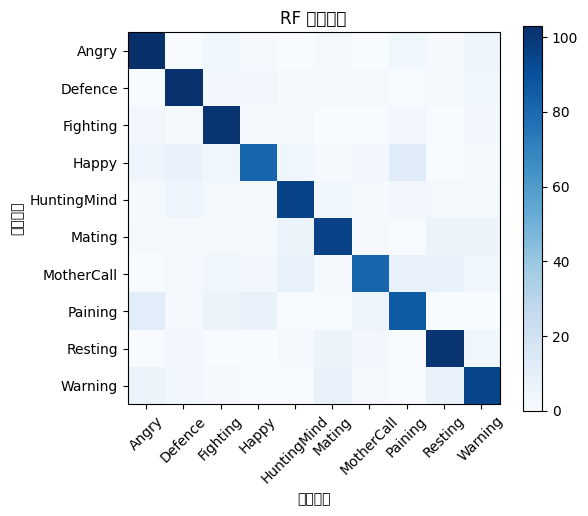

KNN -- Accuracy: 0.7252, F1-Score: 0.7221, AUC: 0.9441


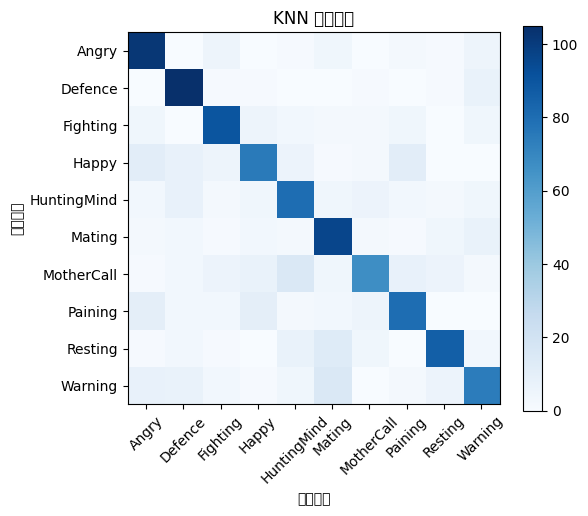

ExtraTrees -- Accuracy: 0.8151, F1-Score: 0.8139, AUC: 0.9785


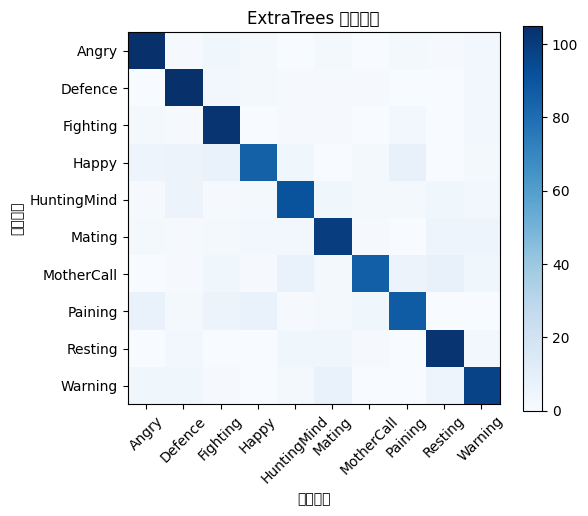

LDA -- Accuracy: 0.6599, F1-Score: 0.6584, AUC: 0.9359


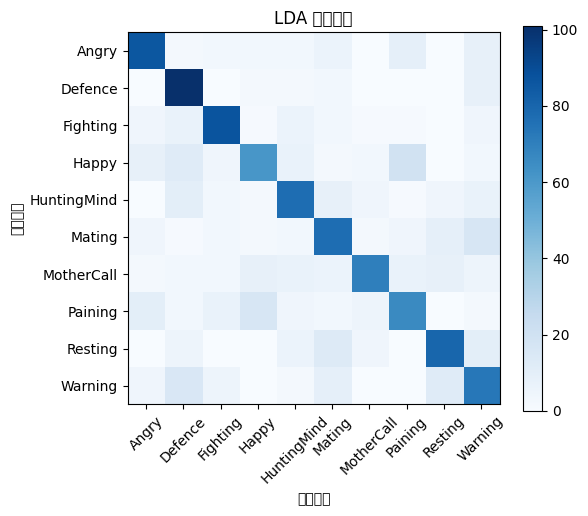

SVM -- Accuracy: 0.6293, F1-Score: 0.6246, AUC: 0.9298


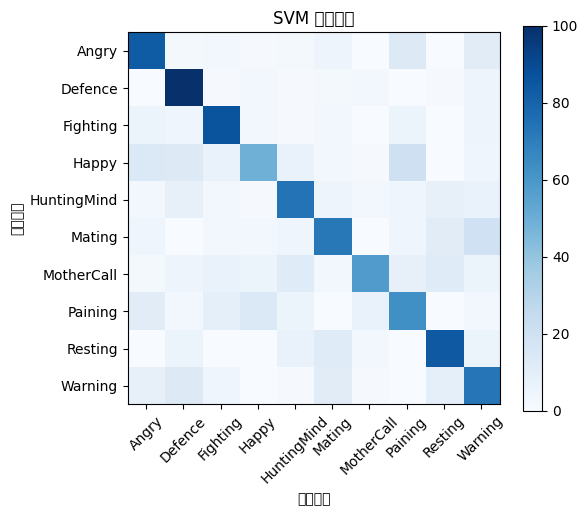

Ensemble -- Accuracy: 0.7642, F1-Score: 0.7623, AUC: 0.9752


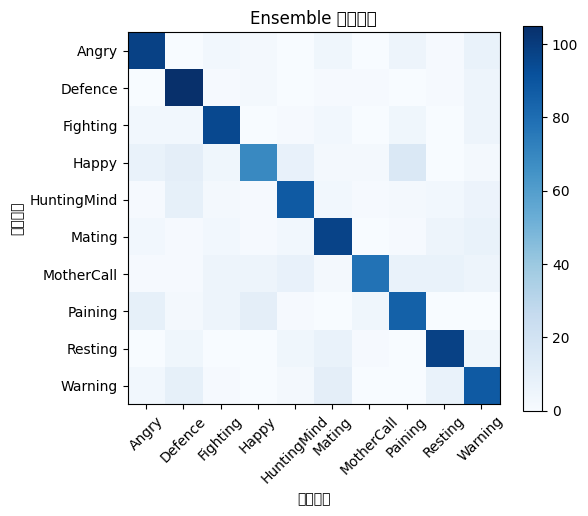

In [39]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except:
        y_prob = None
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    if y_prob is not None and len(np.unique(y_test)) > 1:
        try:
            auc = roc_auc_score(label_binarize(y_test, classes=range(len(classes))),
                                 y_prob, multi_class='ovr')
        except ValueError:
            auc = None
    else:
        auc = None
    cm = confusion_matrix(y_test, y_pred)
    return acc, f1, auc, cm


for name, model in models_list:
    acc, f1, auc, cm = evaluate_model(model, X_test, y_test)
    auc_str = f"{auc:.4f}" if auc is not None else "N/A"
    print(f"{name} -- Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, AUC: {auc_str}")
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{name} 混淆矩阵")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('预测类别')
    plt.ylabel('真实类别')
    plt.show()

GPT4比QwQ强太多了，随便捏的非深度学习网络，ensemble之后都能做到76%准确率

# 10. 绘制ROC曲线

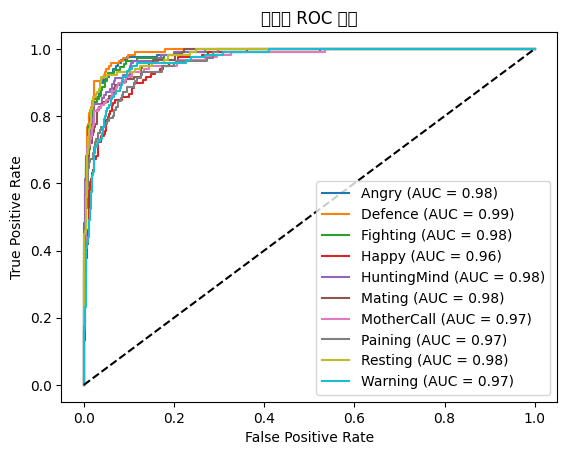

In [40]:
def plot_multiclass_roc(model, X_test, y_test, n_classes):
    # 二值化标签
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    try:
        y_score = model.predict_proba(X_test)
    except:
        print("模型不支持 predict_proba()")
        return
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    # 绘制各类别 ROC 曲线
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('多类别 ROC 曲线')
    plt.legend(loc='best')
    plt.show()

# 绘制 Ensemble 模型的 ROC 曲线
plot_multiclass_roc(voting_clf, X_test, y_test, n_classes=len(classes))